In [1]:
'''
Unsupervised k-means clustering on standardized and cleaned plain text file versions of EEBO-TCP texts. 

Produces a user-specified number of clusters based on term frequency vectorization. 
These clusters are described using the keywords found in their corresponding entries 
in a metadata CSV file made using metadata.py in Stage I. 

The vectorize and cluster functions are adapted from the EarlyPrint Lab: 
    https://earlyprint.org/jupyterbook/unsupervised.html
The topTerms function is adapted from 
    https://pythonprogramminglanguage.com/kmeans-text-clustering/ 
The elbow and intercluster functions are adapted from Yellowbrick's documentation: 
    https://www.scikit-yb.org/en/latest/index.html
'''
import numpy as np
import pandas as pd
from collections import defaultdict,Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# import our own utility functions 
from helping import getTexts,keywords


def vectorize(strings,ids):
    '''
    Vectorizes the texts and returns a dataframe of texts mapping to their TCP IDs. 
    '''
    tfidf = TfidfVectorizer(min_df=2, sublinear_tf=True)
    results = tfidf.fit_transform(strings)
    return pd.DataFrame(results.toarray(), index=ids, columns=tfidf.get_feature_names_out()) # Convert information back to a DataFrame

def cluster(df,ids,num):
    # Create a KMeans instance that will look for a specified number of clusters
    # Random_state parameter helps for reproducibility. 42 is a common choice 
    model = KMeans(n_clusters=num, random_state=42) 
    model.fit(df) 
    kmeans_groups = defaultdict(list)
    for k,v in zip(model.labels_,ids):
        kmeans_groups[k].append(v)
    return kmeans_groups,model

def topTerms(model,df,num):
    print("Top terms per cluster:")
    centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = list(df.columns)
    for i in range(num):
        top = []
        print("Cluster %d:" % i)
        for ind in centroids[i, :20]:
            top.append(terms[ind])
        print(top)

def elbow(model):
    from yellowbrick.cluster.elbow import kelbow_visualizer
    kelbow_visualizer(KMeans(), model, k=(2, 10))
    kelbow_visualizer(KMeans(), model, k=(2, 10),metric='calinski_harabasz')
    kelbow_visualizer(KMeans(), model, k=(2, 10),metric='silhouette')
    
def intercluster(model,num):
    from yellowbrick.cluster import intercluster_distance

    intercluster_distance(KMeans(num),model, embedding='mds') 

def pca(kmeans,df):
    '''
    PCA visualization code comes from https://www.askpython.com/python/examples/plot-k-means-clusters-python \n",
    '''
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df) 
    label = kmeans.fit_predict(pca_results) 
    u_labels = np.unique(label)
    for i in u_labels:
        plt.scatter(pca_results[label == i , 0] , pca_results[label == i , 1] , label = i)
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()

In [15]:
readFile = open('/srv/data/targetTopics.txt','r')
topics = {}
otherSet = ['A10438', 'A34599', 'A34663', 'A34666', 'A34669', 'A34673', 'A34675', 'A34678', 'A34679', 'A34689', 'A34693', 'A71036', 'A80608', 'A80611', 'A80614', 'A80622', 'A80625', 'A80626', 'A80630', 'A80635', 'A80636', 'A80637', 'A80639', 'A80640', 'A84399', 'B20727', 'B20729', 'B20736', 'A00823', 'A06817', 'A07081', 'A10294', 'A10441', 'A10442', 'A10443', 'A10444', 'A10445', 'A10446', 'A10803', 'A11462', 'A13964', 'A14721', 'A16859', 'A18429', 'A18711', 'A19859', 'A20770', 'A27888', 'A30138', 'A35147', 'A43512', 'A43547', 'A43548', 'A43551', 'A43554', 'A43559', 'A45536', 'A46836', 'A46841', 'A55490', 'A55491', 'A55492', 'A55493', 'A55496', 'A68799', 'A70839', 'A72143', 'A75905', 'A77422', 'A85813', 'A86280', 'A86287', 'A86290', 'A86299', 'A86302', 'A86304', 'A90870', 'A90871', 'A90872', 'B02400', 'B03903', 'B07540', 'A01012', 'A34672', 'A10402', 'A09221', 'A02053', 'A13802', 'A16562', 'A18994', 'A13288', 'A10924', 'A68114', 'A37463', 'A15606', 'A05370', 'A68174', 'A72473', 'A09105', 'A05589', 'A19383', 'A11481', 'A04220', 'A11991', 'A04780', 'A04365', 'A06456', 'A18209', 'A16554', 'A02753', 'A20083', 'A12485', 'A16567', 'A01009', 'A07809', 'A10875', 'A19860', 'A13481', 'A57693', 'A29665', 'B13519', 'A08452', 'B08095', 'A19954', 'A19158', 'A12481', 'A00407', 'A02664', 'A13499', 'A08531', 'A47908', 'A22507', 'A11612', 'A19644', 'A04555', 'A13521', 'A02750', 'A09038', 'A19581', 'A16457', 'A05590', 'A01011', 'A01836', 'A10362', 'A31482', 'A19986', 'A47202', 'A01325', 'A02262', 'A01530', 'A03217', 'A19583', 'A14249', 'B13579', 'A02645', 'A07799', 'A19220', 'A20081', 'A04391', 'A09109', 'A00825', 'A02836', 'A18407', 'A17013', 'A02834', 'A02058', 'A17499', 'A09194', 'A16469', 'A03897', 'A10411', 'A13707', 'A19589', 'A13171', 'A04942', 'A20624', 'A00529', 'A04393', 'A08541', 'A15140', 'A07246', 'A12096', 'A10967', 'A16564', 'A06678', 'A19443', 'A10180', 'A07313', 'A01989', 'A15431', 'A07765', 'A15408', 'A50034', 'A03452', 'A11472', 'A04560', 'A16796', 'A13410', 'A02227', 'A05382', 'A03146', 'A03250', 'A14041', 'A08687', 'A68146', 'A05599', 'A68144', 'A13524', 'A03139', 'A15662', 'A01007', 'A68191', 'A19855', 'A07801', 'A00919', 'A17866', 'B07539', 'A12480', 'A03116', 'A15395', 'A12773', 'A32784', 'A10795', 'A04564', 'A03141', 'A14861', 'A07348', 'A01005', 'A13535', 'A11253', 'A02990', 'A75873', 'A11133', 'A10094', 'A17513', 'A73532', 'A19243', 'A68435', 'A09202', 'A12578', 'A68133', 'A00826', 'A71123', 'A18441', 'A01839', 'A20775', 'A04112', 'A11395', 'A04154', 'A69161', 'A01472', 'A07529', 'A10724', 'A27982', 'A01006', 'A20811', 'A72851', 'A16795', 'A09039', 'A19142', 'A19178', 'A13287', 'A16552', 'A00200', 'A06891', 'A20769', 'A63071', 'B07998', 'A73472', 'A06193', 'A20836', 'A03404', 'A10335', 'B12182', 'A09203', 'A16853', 'A93917', 'A08826', 'A16923', 'A68966', 'A04776', 'A12787', 'A13533', 'A12701', 'A07176', 'A11254', 'A02681', 'A04838', 'A16161', 'A09204', 'A07646', 'A13836', 'A72329', 'A20448', 'A10811', 'A19321', 'A11474', 'A08659', 'A22071', 'A17976', 'A19588', 'A06632', 'A68902', 'A01014', 'A19395', 'A70494', 'A01008', 'A08533', 'A13170', 'A05598', 'A00430', 'A01010', 'A11434', 'A01793', 'A04390', 'A01004', 'A11144', 'A20076', 'A19503', 'A13971']
supervisionSet = ['A13290', 'A15050', 'A19590', 'A15387', 'A08829', 'A80633', 'A13172', 'A02614', 'A12788', 'A46842', 'A34674', 'A02324', 'A02495', 'A03065', 'A03144', 'A03149', 'A05237', 'A05597', 'A06137', 'A07768', 'A07769', 'A07834', 'A10357', 'A10821', 'A12718', 'A13294', 'A13821', 'A14722', 'A15033', 'A16309', 'A17981', 'A19072', 'A19368', 'A21108', 'A26262', 'A31106', 'A41427', 'A43507', 'A43514', 'A43524', 'A43528', 'A43531', 'A43533', 'A43535', 'A43545', 'A43553', 'A57329', 'A57355', 'A57360', 'A57532', 'A57590', 'A57652', 'A62166', 'A68617', 'A68619', 'A68764', 'A71305', 'A71306', 'A71307', 'A10368', 'A08874', 'A07883', 'A02239', 'A02826', 'A20847', 'A05074', 'A13574', 'A68132', 'A19476', 'A13173', 'A07466', 'A09195', 'A19622', 'A07894', 'A16282', 'A11408', 'A20983', 'A01395', 'A14194', 'A97352', 'A14916', 'A01095', 'A01342', 'A08017', 'A02464', 'A68197', 'A17808', 'A14028', 'A09208', 'A00617', 'A07448', 'A16206', 'A12535', 'A07267', 'A01403', 'A11862', 'A08536', 'A97346', 'A68163', 'A13043', 'A11931', 'A02775', 'A09169', 'A07559', 'A10743', 'A12317', 'A13042', 'A14293', 'A12461', 'A68659', 'A05410', 'A07439', 'A17810', 'A55555', 'A68944', 'A01231', 'A17958', 'A05569', 'A05594', 'A12533', 'A11383', 'A68445', 'A68465', 'A13830', 'A11516', 'B11307', 'A13049', 'A07363', 'A11863', 'A07680', 'A11954', 'A12598', 'A14770', 'A13053', 'A02858', 'A05412', 'A08239', 'A05339', 'A01864', 'A03411', 'A19232', 'A01512', 'A02848', 'A09741', 'A00580', 'A09197', 'A13415', 'A83496', 'A04194', 'A10389', 'A13217', 'A16286', 'B13659', 'A07225', 'A68463', 'A01115', 'A21106', 'A09500', 'A10231', 'A14292', 'A67927', 'A12609', 'A16482', 'A19602', 'A07628', 'A68475', 'A17140', 'A01764', 'A03066', 'A07415', 'A16489', 'A11467', 'A19211', 'A43598', 'A18974', 'A01364', 'B00136', 'A21071', 'A03096', 'A16264', 'A05289', 'A01160', 'A09569', 'A68283', 'A10690', 'A20238', 'A04911', 'A17848', 'A05184', 'A01043', 'A16308', 'A17832', 'A02484', 'A18028', 'A07280', 'A17310', 'A11878', 'A10668', 'A13980', 'A01991', 'A01128', 'A11493', 'A05105', 'A01811', 'A05335', 'A16275', 'A01161', 'A67926', 'A05751', 'A04863', 'A06471', 'A23464', 'A12119', 'A10228', 'A11464', 'A12824', 'A13820', 'A12738', 'A16248', 'A06134', 'A19179', 'A06425', 'A18501', 'A68202', 'A22928', 'A05331', 'A06786', 'A67922', 'A19354', 'A05094', 'A10417', 'A10436', 'A10439', 'A10440', 'A34659', 'A34936', 'A68633', 'A68635', 'A00201', 'A00268', 'A01749', 'A01932', 'A02494', 'A02655', 'A04813', 'A05601', 'A07605', 'A07886', 'A08052', 'A08166', 'A09899', 'A11788', 'A11831', 'A11842', 'A11884', 'A12458', 'A12460', 'A12466', 'A12596', 'A14510', 'A14803', 'A15069', 'A16221', 'A19313', 'A21083', 'A25867', 'A34856', 'A35994', 'A37432', 'A37936', 'A43513', 'A43537', 'A43543', 'A43544', 'A43550', 'A43552', 'A43556', 'A45999', 'A47317', 'A47319', 'A48714', 'A49991', 'A51598', 'A55497', 'A56021', 'A57347', 'A57367', 'A57374', 'A57391', 'A57453', 'A57465', 'A57483', 'A57518', 'A57525', 'A57589', 'A57605', 'A57617', 'A62162', 'A62165', 'A65185', 'A66847', 'A69046', 'A69149', 'A70942', 'A83297', 'A85817', 'A86296', 'A86306', 'A88366', 'A90869', 'A94198', 'A94783', 'B00052', 'B00963', 'A13128', 'A19029', 'A07512', 'A06935', 'A22171', 'A07516', 'A17074', 'A57517', 'A12615', 'A18694', 'A09213', 'A02333', 'A02171', 'A02795', 'A68000', 'A12470', 'A07788', 'A13705', 'A68903', 'A03251', 'A10376', 'A01216', 'A10822', 'A05269', 'A20442', 'A18686', 'A01003', 'A03229', 'A16495', 'A05570', 'A04795', 'A15706', 'A17788', 'A19863', 'A03123', 'A02472', 'A22340', 'A01871', 'B16236', 'A04364', 'A00214', 'A10774', 'B01237', 'A71317', 'A09209', 'A09478', 'A33630', 'A07903', 'A68945', 'A15466', 'A01622', 'A78796', 'A14026', 'A20784', 'A09733', 'A74609', 'A14850', 'A15862', 'A20114', 'A34660', 'A67457', 'A73929', 'A22559', 'A11027', 'A10530', 'A00985', 'A09011', 'A02606', 'A78325', 'A00271', 'A21082', 'A16993', 'A11529', 'A08162', 'A06788', 'A02059', 'B00767', 'A12313', 'A68946', 'A14164', 'A69334', 'A69175', 'A02764', 'A16718', 'A38817', 'A22173', 'A67893', 'A02626', 'A08440', 'A09909', 'A08210', 'A10314', 'A22250', 'A12218', 'A37552', 'A13417', 'A11056', 'A72217', 'A00947', 'A07915', 'A72397', 'A12274', 'B14980', 'A11416', 'A03476', 'A06317', 'A16711', 'A08258', 'A00518', 'A73547', 'A13460', 'A16313', 'A67125', 'A22364', 'A08538', 'A04763', 'A08150', 'A10354', 'A07510', 'A05165', 'A01108', 'A19312', 'A16490', 'A73966', 'A14517', 'A08154', 'A14516', 'A67920', 'A14512', 'A08698', 'A03451', 'B00838', 'A14519', 'A12830', 'A01017', 'A36830', 'A20443', 'A68509', 'A12691', 'A21080', 'A10378', 'B00564', 'A12545', 'A30295', 'A10373', 'A69354', 'A14514', 'A73588', 'A13781', 'A10725', 'A22435', 'A14871', 'A13959', 'A14671', 'A09826', 'A11767', 'B14988', 'A19942', 'A22195', 'A69205', 'A16306', 'A13423', 'A09010', 'A00549', 'A04223', 'A10588', 'A04581', 'A05182', 'A22537', 'A68246', 'A22439', 'A20509', 'A06701', 'B09574', 'A14958', 'A13516', 'A03461', 'A17374', 'A06694', 'A09900', 'A12330', 'A02421', 'A10591', 'A14511', 'A13506', 'A14521', 'A22447', 'A51736', 'A19763', 'A16139', 'A00021', 'A22354', 'A22169', 'A02201', 'A03734', 'A15309', 'A59054', 'A35908', 'A21084', 'A15036', 'A14526', 'A07604', 'A69259', 'A01426', 'A14513', 'A14520', 'A03477', 'A13057', 'A03702', 'A17260', 'A22363', 'A22328', 'A22327', 'A14524', 'A11786', 'A16507', 'A78324', 'A10526', 'A14518', 'A34504'] 
for line in readFile:
    tcpID =  line.split(':')[0].strip('.txt')
    if tcpID in supervisionSet: 
        topic = line.split(':')[1].strip()
        topics[tcpID] = topic.split(' ')
readFile.close()

In [34]:
folder = '/srv/data/supervisionCompany'

info = getTexts(folder)
kwdict = keywords('/srv/data/metadata/tuning/target.csv')
for idx,ID in enumerate(info[1]):
    kWords = (list(kwdict[ID][0]) * 200)
    info[0][idx] += ' '.join(kWords)
    info[0][idx] += ' '.join(topics[ID]*200)
df = vectorize(info[0],info[1])

Top terms per cluster:
Cluster 0:
['broadsides', 'and', 'of', 'england', 'history', 'parliament', 'london', 'majesty', 'king', 'take', 'relations', 'god', 'legislation', 'good', 'person', 'lord', 'india', 'law', 'give', 'east']
Cluster 1:
['take', 'good', 'give', 'king', 'god', 'country', 'ship', 'find', 'land', 'sea', 'people', 'bring', 'history', 'mean', 'england', 'send', 'use', 'cause', 'prince', 'hand']
Cluster 2:
['colonial', 'virginia', 'period', 'plantation', 'islands', 'monopolies', 'history', 'colonies', 'broadsides', 'bermuda', 'tobacco', 'colony', 'adventurer', 'commerce', 'james', 'good', 'person', 'philpotlane', 'industry', 'lotteries']
Cluster 3:
['king', 'take', 'prince', 'give', 'good', 'emperor', 'roman', 'law', 'son', 'god', 'city', 'war', 'rome', 'people', 'use', 'speak', 'duke', 'cause', 'among', 'pope']


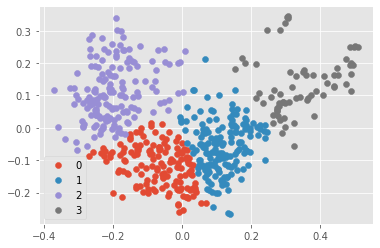

<Figure size 1440x720 with 0 Axes>

In [35]:
groups,model = cluster(df,info[1],4)
topTerms(model,df,4)
pca(model,df)

In [ ]:
for k,v in groups.items():
    print(k, ': ',v)

In [ ]:
'''Group 2 & 0 are NON company- or travel-related'''
group2 = ['A34599', 'A34663', 'A34666', 'A34669', 'A34673', 'A34674', 'A34675', 'A34678', 'A34679', 'A34689', 'A34693', 'A71036', 'A80608', 'A80611', 'A80614', 'A80622', 'A80625', 'A80626', 'A80630', 'A80633', 'A80635', 'A80636', 'A80637', 'A80639', 'A80640', 'A84399', 'B20727', 'B20729', 'B20736', 'A10441', 'A10442', 'A10443', 'A10444', 'A10445', 'A10446', 'A11462', 'A13290', 'A13964', 'A14721', 'A16859', 'A18429', 'A18711', 'A19859', 'A20770', 'A30138', 'A35147', 'A43512', 'A43547', 'A43548', 'A43551', 'A43554', 'A43559', 'A45536', 'A46836', 'A46841', 'A46842', 'A55491', 'A72143', 'A75905', 'A77422', 'A85813', 'A86280', 'A86287', 'A86290', 'A86299', 'A86302', 'A86304', 'A90870', 'A90871', 'A90872', 'B02400', 'B03903', 'B07540', 'A01012', 'A34672', 'A16562', 'A18994', 'A13288', 'A10924', 'A37463', 'A05370', 'A68174', 'A09105', 'A11481', 'A04220', 'A04780', 'A04365', 'A18209', 'A16554', 'A02753', 'A12485', 'A16567', 'A01009', 'A07809', 'A10875', 'A19860', 'A57693', 'A13172', 'A29665', 'B08095', 'A19954', 'A12481', 'A00407', 'A02664', 'A08531', 'A47908', 'A22507', 'A15050', 'A19581', 'A01011', 'A31482', 'A19986', 'A47202', 'A01325', 'A01530', 'A19583', 'B13579', 'A07799', 'A19220', 'A04391', 'A09109', 'A15387', 'A17013', 'A02834', 'A02058', 'A17499', 'A08829', 'A03897', 'A13707', 'A19589', 'A13171', 'A20624', 'A02614', 'A04393', 'A08541', 'A12788', 'A12096', 'A10967', 'A10180', 'A15431', 'A07765', 'A15408', 'A03452', 'A16796', 'A05382', 'A03146', 'A68146', 'A03139', 'A01007', 'A19855', 'A07801', 'A00919', 'A17866', 'B07539', 'A12480', 'A15395', 'A32784', 'A10795', 'A03141', 'A14861', 'A07348', 'A01005', 'A13535', 'A11253', 'A02990', 'A75873', 'A10094', 'A17513', 'A19243', 'A71123', 'A18441', 'A20775', 'A04112', 'A04154', 'A69161', 'A01472', 'A07529', 'A10724', 'A01006', 'A72851', 'A16795', 'A19142', 'A19178', 'A13287', 'A00200', 'A20769', 'A63071', 'B07998', 'A06193', 'A10335', 'A16853', 'A93917', 'A08826', 'A68966', 'A04776', 'A13533', 'A12701', 'A02681', 'A04838', 'A16161', 'A07646', 'A13836', 'A72329', 'A19321', 'A19590', 'A17976', 'A19588', 'A06632', 'A68902', 'A01014', 'A19395', 'A70494', 'A01008', 'A08533', 'A13170', 'A00430', 'A01010', 'A04390', 'A01004', 'A11144', 'A19503', 'A13971']
group0 = ['A10438', 'A00823', 'A06817', 'A07081', 'A10294', 'A10803', 'A27888', 'A55490', 'A55492', 'A55493', 'A55496', 'A68799', 'A70839', 'A10402', 'A09221', 'A02053', 'A13802', 'A68114', 'A15606', 'A72473', 'A05589', 'A19383', 'A11991', 'A06456', 'A20083', 'A13481', 'B13519', 'A08452', 'A19158', 'A13499', 'A11612', 'A19644', 'A04555', 'A13521', 'A02750', 'A09038', 'A16457', 'A05590', 'A01836', 'A10362', 'A02262', 'A03217', 'A14249', 'A02645', 'A20081', 'A00825', 'A02836', 'A18407', 'A09194', 'A16469', 'A10411', 'A04942', 'A00529', 'A15140', 'A07246', 'A16564', 'A06678', 'A19443', 'A07313', 'A01989', 'A50034', 'A11472', 'A04560', 'A13410', 'A02227', 'A03250', 'A14041', 'A08687', 'A05599', 'A68144', 'A13524', 'A15662', 'A68191', 'A03116', 'A12773', 'A04564', 'A11133', 'A73532', 'A68435', 'A09202', 'A12578', 'A68133', 'A00826', 'A01839', 'A11395', 'A27982', 'A20811', 'A09039', 'A16552', 'A06891', 'A73472', 'A20836', 'A03404', 'B12182', 'A09203', 'A16923', 'A12787', 'A07176', 'A11254', 'A09204', 'A20448', 'A10811', 'A11474', 'A08659', 'A22071', 'A05598', 'A11434', 'A01793', 'A20076']
#keep are the files from Groups 2 & 0 that we want to add to our company/voyage corpus 
keep = ['A13290','A15050','A19590','A15387','A08829','A80633','A13172','A02614','A12788'
        ,'A46842','A34674']

'''Groups 1 & 3 are company- or travel-related'''
group1 = ['A02324', 'A02495', 'A03065', 'A03144', 'A03149', 'A05237', 'A05597', 'A06137', 'A07768', 'A07769', 'A07834', 'A10357', 'A10821', 'A12718', 'A13294', 'A13821', 'A14722', 'A15033', 'A16309', 'A17981', 'A19072', 'A19368', 'A21108', 'A26262', 'A31106', 'A41427', 'A43507', 'A43514', 'A43524', 'A43528', 'A43531', 'A43533', 'A43535', 'A43545', 'A43553', 'A57329', 'A57355', 'A57360', 'A57532', 'A57590', 'A57652', 'A62166', 'A68617', 'A68619', 'A68764', 'A71305', 'A71306', 'A71307', 'A10368', 'A08874', 'A07883', 'A02239', 'A02826', 'A20847', 'A05074', 'A13574', 'A68132', 'A19476', 'A13173', 'A07466', 'A09195', 'A19622', 'A07894', 'A16282', 'A11408', 'A20983', 'A01395', 'A14194', 'A97352', 'A14916', 'A01095', 'A01342', 'A08017', 'A02464', 'A68197', 'A17808', 'A14028', 'A09208', 'A00617', 'A07448', 'A16206', 'A12535', 'A07267', 'A01403', 'A11862', 'A08536', 'A97346', 'A68163', 'A13043', 'A11931', 'A02775', 'A09169', 'A07559', 'A10743', 'A12317', 'A13042', 'A14293', 'A12461', 'A68659', 'A05410', 'A07439', 'A17810', 'A55555', 'A68944', 'A01231', 'A17958', 'A05569', 'A05594', 'A12533', 'A11383', 'A68445', 'A68465', 'A13830', 'A11516', 'B11307', 'A13049', 'A07363', 'A11863', 'A07680', 'A11954', 'A12598', 'A14770', 'A13053', 'A02858', 'A05412', 'A08239', 'A05339', 'A01864', 'A03411', 'A19232', 'A01512', 'A02848', 'A09741', 'A00580', 'A09197', 'A13415', 'A83496', 'A04194', 'A10389', 'A13217', 'A16286', 'B13659', 'A07225', 'A68463', 'A01115', 'A21106', 'A09500', 'A10231', 'A14292', 'A67927', 'A12609', 'A16482', 'A19602', 'A07628', 'A68475', 'A17140', 'A01764', 'A03066', 'A07415', 'A16489', 'A11467', 'A19211', 'A43598', 'A18974', 'A01364', 'B00136', 'A21071', 'A03096', 'A16264', 'A05289', 'A01160', 'A09569', 'A68283', 'A10690', 'A20238', 'A04911', 'A17848', 'A05184', 'A01043', 'A16308', 'A17832', 'A02484', 'A18028', 'A07280', 'A17310', 'A11878', 'A10668', 'A13980', 'A01991', 'A01128', 'A11493', 'A05105', 'A01811', 'A05335', 'A16275', 'A01161', 'A67926', 'A05751', 'A04863', 'A06471', 'A23464', 'A12119', 'A10228', 'A11464', 'A12824', 'A13820', 'A12738', 'A16248', 'A06134', 'A19179', 'A06425', 'A18501', 'A68202', 'A22928', 'A05331', 'A06786', 'A67922', 'A19354', 'A05094']
group3 = ['A10417', 'A10436', 'A10439', 'A10440', 'A34659', 'A34936', 'A68633', 'A68635', 'A00201', 'A00268', 'A01749', 'A01932', 'A02494', 'A02655', 'A04813', 'A05601', 'A07605', 'A07886', 'A08052', 'A08166', 'A09899', 'A11788', 'A11831', 'A11842', 'A11884', 'A12458', 'A12460', 'A12466', 'A12596', 'A14510', 'A14803', 'A15069', 'A16221', 'A19313', 'A21083', 'A25867', 'A34856', 'A35994', 'A37432', 'A37936', 'A43513', 'A43537', 'A43543', 'A43544', 'A43550', 'A43552', 'A43556', 'A45999', 'A47317', 'A47319', 'A48714', 'A49991', 'A51598', 'A55497', 'A56021', 'A57347', 'A57367', 'A57374', 'A57391', 'A57453', 'A57465', 'A57483', 'A57518', 'A57525', 'A57589', 'A57605', 'A57617', 'A62162', 'A62165', 'A65185', 'A66847', 'A69046', 'A69149', 'A70942', 'A83297', 'A85817', 'A86296', 'A86306', 'A88366', 'A90869', 'A94198', 'A94783', 'B00052', 'B00963', 'A13128', 'A19029', 'A07512', 'A06935', 'A22171', 'A07516', 'A17074', 'A57517', 'A12615', 'A18694', 'A09213', 'A02333', 'A02171', 'A02795', 'A68000', 'A12470', 'A07788', 'A13705', 'A68903', 'A03251', 'A10376', 'A01216', 'A10822', 'A05269', 'A20442', 'A18686', 'A01003', 'A03229', 'A16495', 'A05570', 'A04795', 'A15706', 'A17788', 'A19863', 'A03123', 'A02472', 'A22340', 'A01871', 'B16236', 'A04364', 'A00214', 'A10774', 'B01237', 'A71317', 'A09209', 'A09478', 'A33630', 'A07903', 'A68945', 'A15466', 'A01622', 'A78796', 'A14026', 'A20784', 'A09733', 'A74609', 'A14850', 'A15862', 'A20114', 'A34660', 'A67457', 'A73929', 'A22559', 'A11027', 'A10530', 'A00985', 'A09011', 'A02606', 'A78325', 'A00271', 'A21082', 'A16993', 'A11529', 'A08162', 'A06788', 'A02059', 'B00767', 'A12313', 'A68946', 'A14164', 'A69334', 'A69175', 'A02764', 'A16718', 'A38817', 'A22173', 'A67893', 'A02626', 'A08440', 'A09909', 'A08210', 'A10314', 'A22250', 'A12218', 'A37552', 'A13417', 'A11056', 'A72217', 'A00947', 'A07915', 'A72397', 'A12274', 'B14980', 'A11416', 'A03476', 'A06317', 'A16711', 'A08258', 'A00518', 'A73547', 'A13460', 'A16313', 'A67125', 'A22364', 'A08538', 'A04763', 'A08150', 'A10354', 'A07510', 'A05165', 'A01108', 'A19312', 'A16490', 'A73966', 'A14517', 'A08154', 'A14516', 'A67920', 'A14512', 'A08698', 'A03451', 'B00838', 'A14519', 'A12830', 'A01017', 'A36830', 'A20443', 'A68509', 'A12691', 'A21080', 'A10378', 'B00564', 'A12545', 'A30295', 'A10373', 'A69354', 'A14514', 'A73588', 'A13781', 'A10725', 'A22435', 'A14871', 'A13959', 'A14671', 'A09826', 'A11767', 'B14988', 'A19942', 'A22195', 'A69205', 'A16306', 'A13423', 'A09010', 'A00549', 'A04223', 'A10588', 'A04581', 'A05182', 'A22537', 'A68246', 'A22439', 'A20509', 'A06701', 'B09574', 'A14958', 'A13516', 'A03461', 'A17374', 'A06694', 'A09900', 'A12330', 'A02421', 'A10591', 'A14511', 'A13506', 'A14521', 'A22447', 'A51736', 'A19763', 'A16139', 'A00021', 'A22354', 'A22169', 'A02201', 'A03734', 'A15309', 'A59054', 'A35908', 'A21084', 'A15036', 'A14526', 'A07604', 'A69259', 'A01426', 'A14513', 'A14520', 'A03477', 'A13057', 'A03702', 'A17260', 'A22363', 'A22328', 'A22327', 'A14524', 'A11786', 'A16507', 'A78324', 'A10526', 'A14518', 'A34504']
clusters = [group0,group1,group2,group3]
kw = [[],[],[],[]]
kwdict = keywords('/srv/data/metadata/tuning/target.csv')
for idx,group in enumerate(clusters):
    for name in group: 
        kw[idx].extend(kwdict[name][0])

topics = [[],[],[],[]]
ids = [{},{},{},{}]
names = ['Group 0','Group 1','Group 2','Group 3']
readFile = open('/srv/data/targetTopics.txt','r')
titles = pd.read_csv('/srv/data/metadata/tuning/target.csv')
titleDict = {}
for idx,tcpID in enumerate(titles['id']):
    titleDict[tcpID] = titles['title'][idx]

for line in readFile:
    tcpID = line.split(':')[0]
    tcpID = tcpID.split('.')[0]
    topicStr = line.split(':')[1].strip()
    topic = topicStr.split(' ')
    for idx,group in enumerate(clusters):
        if tcpID in group: 
            topics[idx].extend(topic) 
            ids[idx].update({tcpID: topicStr})

# for idx, topicsList in enumerate(topics):
    # if idx == 1 or 3:
    #     for tcpID,topicStr in ids[idx].items(): 
    #         print(tcpID,'\n',f'Title: {titleDict[tcpID]}','\n',f'Topic Words: {topicStr}','\n',f'Keywords Metadata: {kwdict[tcpID][0]}','\n\n')
    # common = Counter(topicsList).most_common(n=75)
    # print(names[idx] + ' Topic Words: ' + str(common) + '\n')
    # print('Keywords: '+ str(Counter(kw[idx]).most_common(n=30)) + '\n\n')

supervision = keep.copy()
supervision.extend(group1)
supervision.extend(group3)
print(len(supervision))